Size: (914, 1225, 3) 	 MaxI: 255 	 MinI: 0


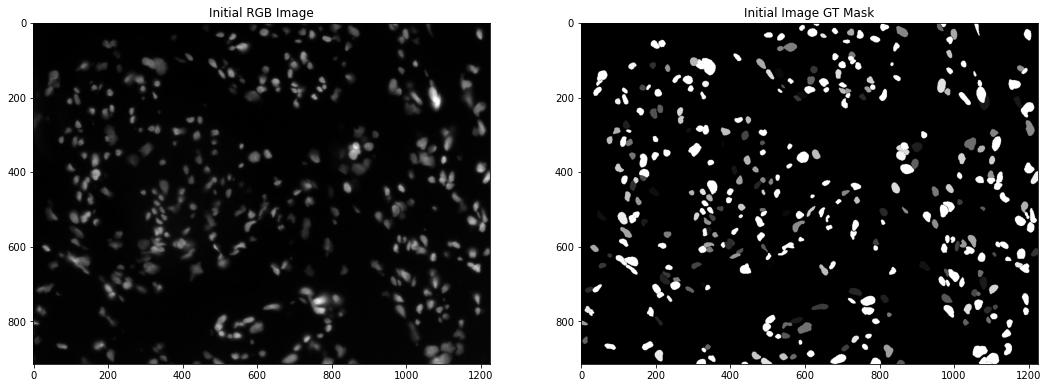

In [1]:
import os
import numpy as np
import cv2
import skimage
import matplotlib.pyplot as plt
from scipy.signal import medfilt2d

def readCorrectLab(img_path): # function to properly read tif label file
    img = cv2.imread(img_path,-1)
    alpha = img.max()/255 # Contrast control 
    beta = 0 # Brightness control (0-100)
    properImg = cv2.convertScaleAbs(img, alpha=alpha, beta=beta) # convert 0-255 range and to uint8
    return properImg

sample_img_rgb = cv2.imread('training_data/rawimages/Ganglioneuroblastoma_4.tif',-1) # Shape: (914, 1225, 3)
sample_img_mask = readCorrectLab('training_data/groundtruth/Ganglioneuroblastoma_4.tif') # Read the GT Label File

print('Size:',sample_img_rgb.shape, '\t MaxI:',sample_img_rgb.max(),'\t MinI:',sample_img_rgb.min()) # Image Properties

plt.figure(figsize=(18,18))
plt.subplot(121)
plt.title('Initial RGB Image')
plt.imshow(sample_img_rgb)

plt.subplot(122)
plt.title('Initial Image GT Mask')
plt.imshow(sample_img_mask,cmap='gray')

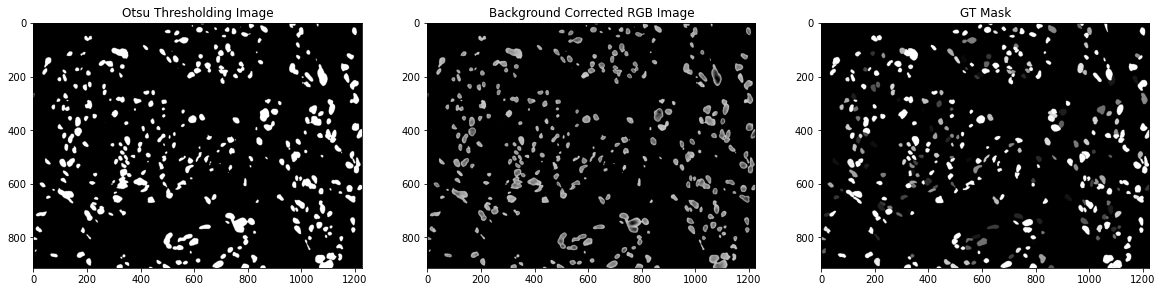

In [2]:
# turning the grey areas in background to black!

# step 1: Convert to Gray + Gausian Blur
img_blur = cv2.GaussianBlur(cv2.cvtColor(sample_img_rgb,cv2.COLOR_BGR2GRAY),(5,5),0)

# step 2: use either adaptive thresholding or otsu thresholding to binarize the image to get foreground mask (cells = 1, background=0)
_, th_otsu = cv2.threshold(img_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.title('Otsu Thresholding Image')
plt.imshow(th_otsu,cmap='gray')

# step 3: multiply the mask channel wise with rgb to get RGB with corrected background!
bmask = np.repeat(th_otsu[:, :, np.newaxis], 3, axis=2)
corrected_rgb = sample_img_rgb*bmask

plt.subplot(132)
plt.title('Background Corrected RGB Image')
plt.imshow(corrected_rgb)

plt.subplot(133)
plt.title('GT Mask')
plt.imshow(sample_img_mask,cmap='gray')

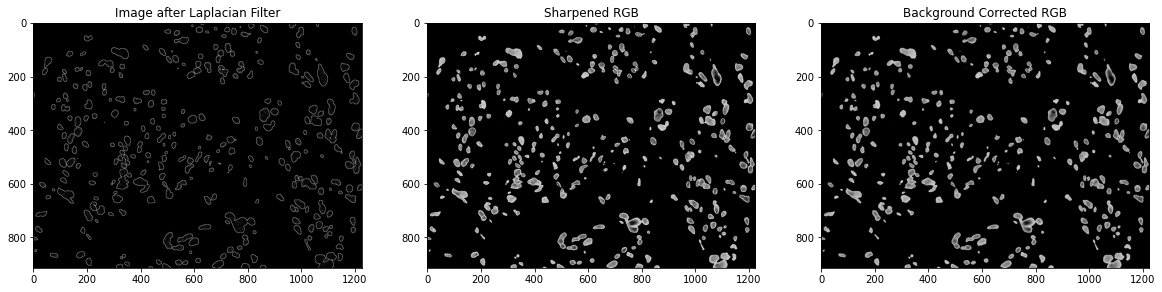

In [3]:
# sharpen the rgb image by applying laplacian filters
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32) # shaprpening kernel
imgLaplacian = cv2.filter2D(corrected_rgb, cv2.CV_32F, kernel) # convert to higher depth to have more range and 
sharp = np.float32(corrected_rgb)
imgResult = sharp - imgLaplacian

imgResult = np.clip(imgResult, 0, 255)
imgResult = imgResult.astype('uint8')

imgLaplacian = np.clip(imgLaplacian, 0, 255)
imgLaplacian = np.uint8(imgLaplacian)

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.title('Image after Laplacian Filter')
plt.imshow(imgLaplacian)

plt.subplot(132)
plt.title('Sharpened RGB')
plt.imshow(imgResult)

plt.subplot(133)
plt.title('Background Corrected RGB')
plt.imshow(corrected_rgb)

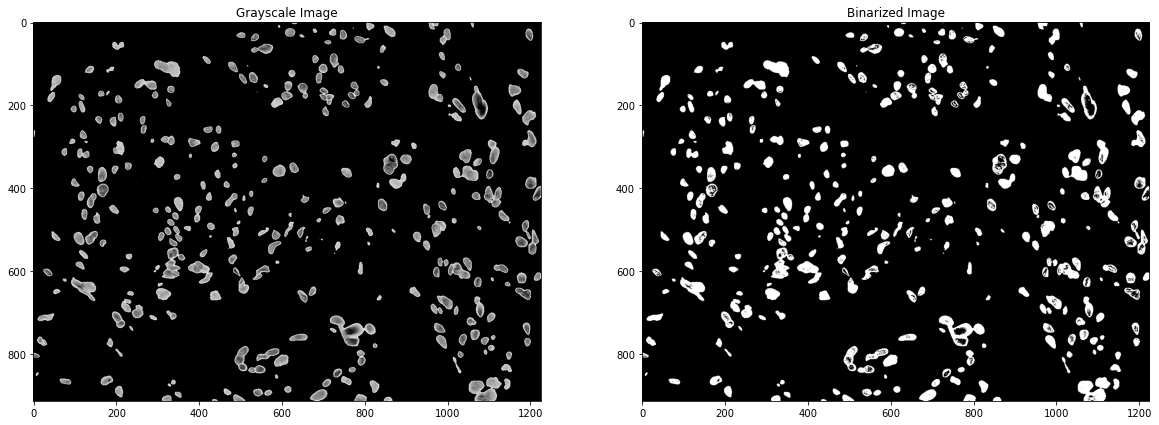

In [4]:
# Now convert this new rgb image to gray and binary

bw = cv2.cvtColor(imgResult, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title('Grayscale Image')
plt.imshow(bw, cmap='gray')

_, bw = cv2.threshold(bw, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

plt.subplot(122)
plt.title('Binarized Image')
plt.imshow(bw, cmap='gray')

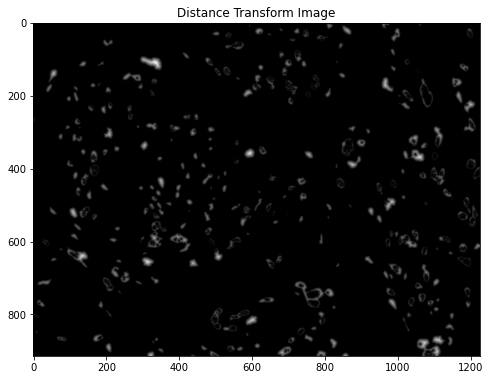

In [5]:
# Perform the distance transform algorithm

dist = cv2.distanceTransform(bw, cv2.DIST_L2, 3)
# Normalize the distance image for range = {0.0, 1.0} so we can visualize and threshold it
dist = cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)

plt.figure(figsize=(8,8))
plt.title('Distance Transform Image')
plt.imshow(dist, cmap='gray')

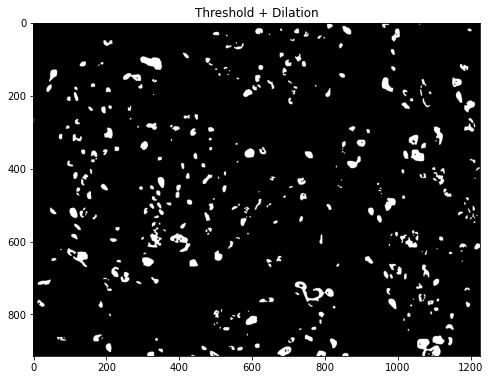

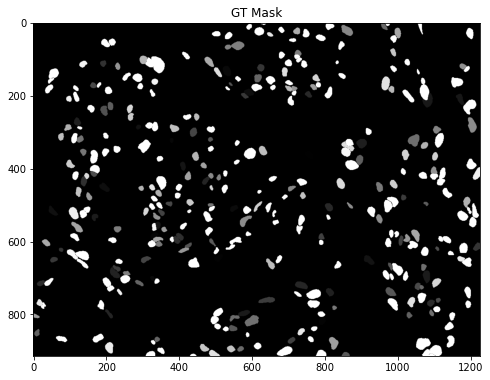

In [6]:
# Threshold to obtain the peaks and perform dilation to extract only the peaks of the Distance Transform Image (markers to foreground objects)
_, dist = cv2.threshold(dist, 0.2, 1.0, cv2.THRESH_BINARY)
kerneld = np.ones((3,3), dtype=np.uint8)
dist = cv2.dilate(dist, kerneld)

plt.figure(figsize=(8,8))
plt.title('Threshold + Dilation')
plt.imshow(dist, cmap='gray')

plt.figure(figsize=(8,8))
plt.title('GT Mask')
plt.imshow(sample_img_mask, cmap='gray')

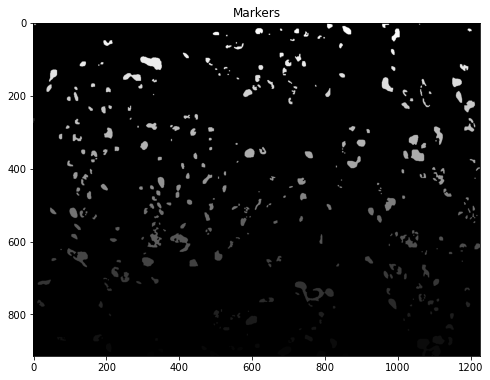

In [7]:
dist_8u = dist.astype('uint8')

# Find total markers
contours, _ = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)

#Draw the foreground markers
for i in range(len(contours)):
    cv2.drawContours(markers, contours, i, (i+1), -1)
    
# Draw the background marker
cv2.circle(markers, (5,5), 3, (255,255,255), -1)

plt.figure(figsize=(8,8))
plt.title('Markers')
plt.imshow(markers*10000, cmap='gray')

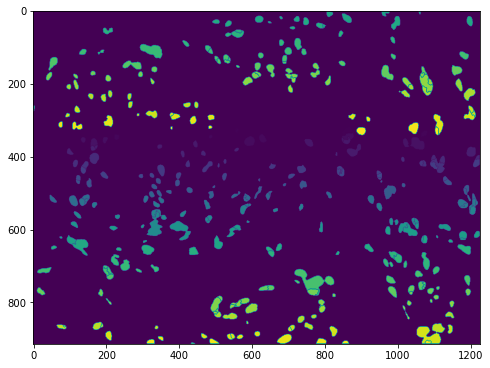

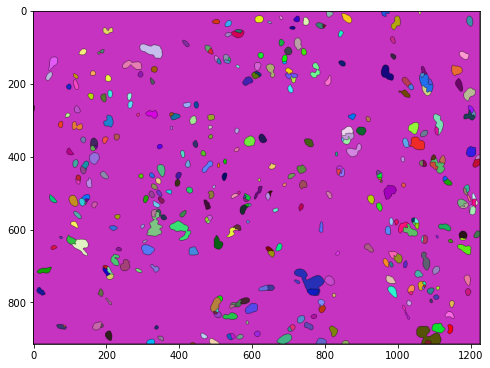

In [8]:
import random as rng
# Apply Watershed and Visualize

cv2.watershed(imgResult, markers)

mark = markers.astype('uint8')
mark = cv2.bitwise_not(mark)

plt.figure(figsize=(8,8))
plt.imshow(mark)

# Generate random colors
colors = []
for contour in contours:
    colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))
    
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)

# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]
            
plt.figure(figsize=(8,8))
plt.imshow(dst)
plt.imsave('Watershed.png',dst)

In [9]:
plt.imsave('ErrorGT_mask.png',sample_img_mask)

(array([  0,   0,   0, ..., 913, 913, 913], dtype=int64), array([   0,    0,    0, ..., 1224, 1224, 1224], dtype=int64), array([0, 1, 2, ..., 0, 1, 2], dtype=int64))


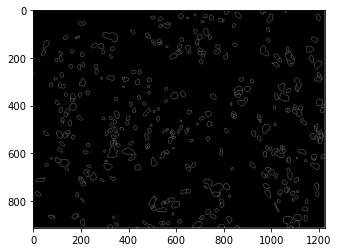

In [60]:
plt.imshow(sing_mask[:,:,365],cmap='gray')

print(np.where(dst == [0,0,0]))